In [1]:
pip install yfinance


  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------------- -------------------------- 1.0/3.0 MB 8.4 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 9.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
  Using cached cffi-1.17.1-cp39-cp39-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached beautifulsoup4-4.13.4-py

In [15]:
# 📌 Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense



In [16]:
# 📈 Download stock data
df = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
df = df[['Close']]
df['MA20'] = df['Close'].rolling(window=20).mean()  # 20-day moving average

C:\Users\yuvan\AppData\Local\Temp\ipykernel_9984\3740917340.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [17]:
# 📊 RSI Calculation
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df.dropna(inplace=True)

In [18]:
# 🔄 Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'MA20', 'RSI']])

In [19]:
# 🧱 Create sequences
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i][0])  # Predicting only Close
X, y = np.array(X), np.array(y)

In [20]:
# 📂 Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [21]:
# 🧠 Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 3)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
61/61 [==============================] - 3s 21ms/step - loss: 0.0067
Epoch 2/15
61/61 [==============================] - 1s 21ms/step - loss: 3.8071e-04
Epoch 3/15
61/61 [==============================] - 1s 22ms/step - loss: 3.0274e-04
Epoch 4/15
61/61 [==============================] - 1s 23ms/step - loss: 2.6260e-04
Epoch 5/15
61/61 [==============================] - 1s 21ms/step - loss: 2.6441e-04
Epoch 6/15
61/61 [==============================] - 1s 22ms/step - loss: 2.4282e-04
Epoch 7/15
61/61 [==============================] - 1s 22ms/step - loss: 2.4353e-04
Epoch 8/15
61/61 [==============================] - 1s 21ms/step - loss: 2.5146e-04
Epoch 9/15
61/61 [==============================] - 1s 21ms/step - loss: 2.1787e-04
Epoch 10/15
61/61 [==============================] - 1s 20ms/step - loss: 1.9988e-04
Epoch 11/15
61/61 [==============================] - 1s 21ms/step - loss: 2.4579e-04
Epoch 12/15
61/61 [==============================] - 1s 21ms/step - loss: 2.15

In [22]:
# 📈 Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((predictions.shape[0], 2))]))[:, 0]
actual = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))]))[:, 0]

16/16 [==============================] - 1s 9ms/step


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Real and predicted (already inverse scaled earlier)
y_true = actual
y_pred = predictions

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 5.38
RMSE: 7.06
R² Score: 0.9301


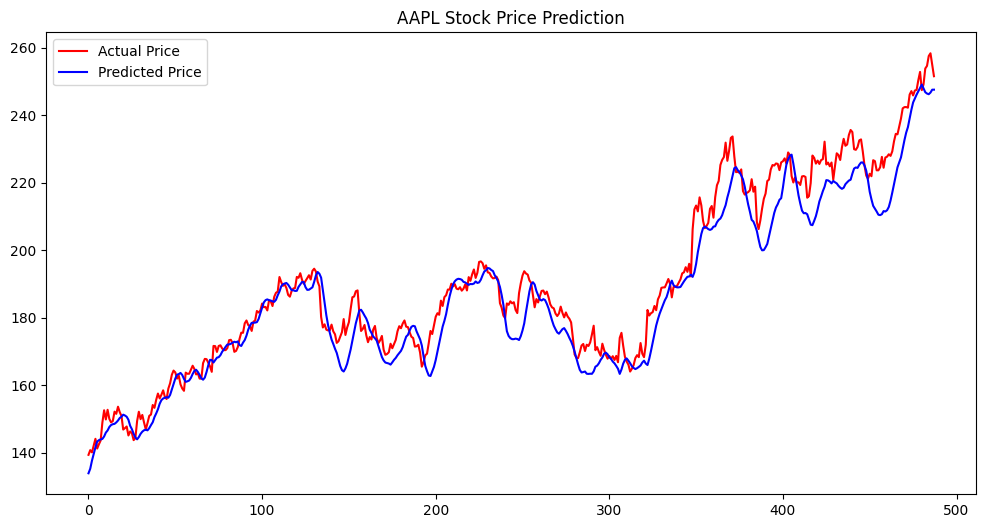

In [23]:
# 📊 Plot
plt.figure(figsize=(12, 6))
plt.plot(actual, color='red', label='Actual Price')
plt.plot(predictions, color='blue', label='Predicted Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

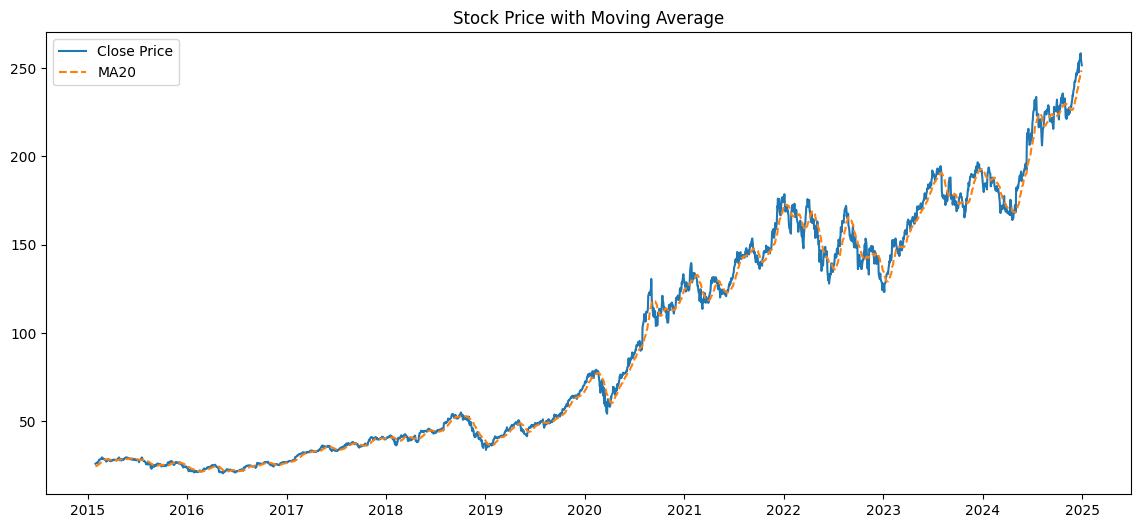

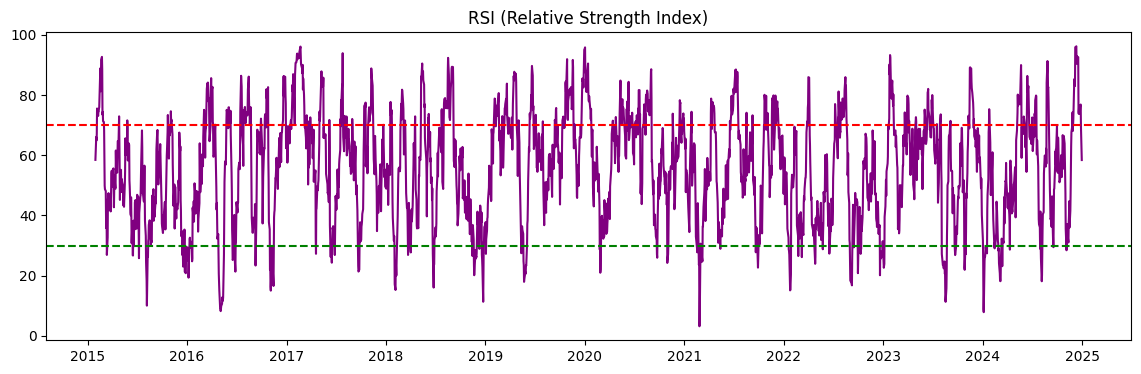

In [25]:
# 📉 Visualize Moving Average + RSI
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA20'], label='MA20', linestyle='--')
plt.title('Stock Price with Moving Average')
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df['RSI'], color='purple')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('RSI (Relative Strength Index)')
plt.show()
